## Import Packages and Set Directories

In [2]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [22]:
# Read the data
bc_file = os.path.join(data_dir, 'business_cycle_divided.csv')
bc_df = pd.read_csv(bsc_file)
# Format business cycle Year_Month
bc_df['Year_Month'] = pd.to_datetime(bc_df['Year'].astype(str) + '-' + bc_df['Month'].astype(str))
bc_df['Year_Month'] = pd.to_datetime(bc_df['Year_Month'])
bc_df.drop(columns=['Year', 'Month'], inplace=True)
bc_df

,Cof_idx,Recovery,Expansion,Downturn,Depression,Recession,Year_Month
0,-1.2,0,0,0,1,0,1990-01-01
1,-1.4,0,0,0,1,0,1990-02-01
2,-0.8,0,0,0,1,0,1990-03-01
3,-1.4,0,0,0,1,0,1990-04-01
4,-1.1,0,0,0,1,0,1990-05-01
...,...,...,...,...,...,...,...
406,-7.7,1,0,0,0,0,2023-11-01
407,-7.1,1,0,0,0,0,2023-12-01
408,-7.1,1,0,0,0,0,2024-01-01
409,-7.1,1,0,0,0,0,2024-02-01


## Business Cycles Visualization

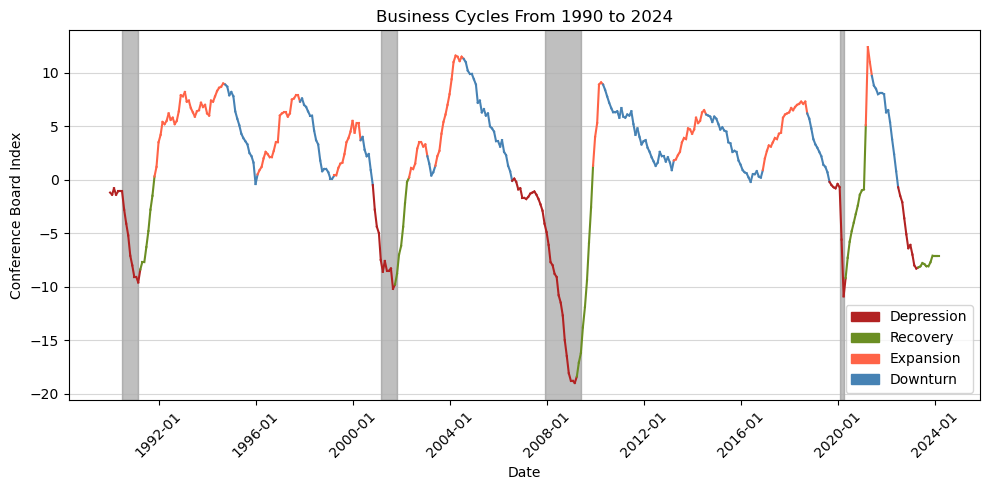

In [30]:
# Find the start and end dates of recession periods
recession_periods = []
in_recession = False
for i, row in bc_df.iterrows():
    if row['Recession'] == 1 and not in_recession:        
        start_date = row['Year_Month']  # Start of a new recession
        in_recession = True
    elif row['Recession'] == 0 and in_recession:        
        end_date = bc_df.iloc[i-1]['Year_Month']  # End of current recession
        recession_periods.append((start_date, end_date))
        in_recession = False

# Plot the LEI
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'Depression': 'firebrick', 'Recovery': 'olivedrab', 'Expansion': 'tomato', 'Downturn': 'steelblue'}
# Plot each segment with appropriate color
for i in range(len(bc_df) - 1):
    start_date = bc_df.iloc[i]['Year_Month']
    end_date = bc_df.iloc[i + 1]['Year_Month']
    for phase in colors:
        if bc_df.iloc[i][phase] == 1:
            ax.plot([start_date, end_date], [bc_df.iloc[i]['Cof_idx'], bc_df.iloc[i + 1]['Cof_idx']], color=colors[phase])
# Shade the recession periods
for start_date, end_date in recession_periods:
    ax.axvspan(start_date, end_date + pd.Timedelta(days=1), color='grey', alpha=0.5)
# Set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.grid(True, alpha=0.5)
# Add custom legend for business cycles
legend_elements = [Patch(color=colors[phase], label=phase) for phase in colors]
plt.legend(handles=legend_elements)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Conference Board Index')
plt.title('Business Cycles From 1990 to 2024')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'business_cycles_divided.png'))
plt.show()